In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
df = pd.read_csv('data/cc_data_processed.csv')

In [3]:
# Use date as index
df.index = pd.to_datetime(df['Transaction Date'])
df.drop('Transaction Date', axis = 1, inplace = True, errors='ignore')
df.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Age
Transaction Date,,,,,,
2019-07-01,credit_card,male,Red Robin,Eating Places,15.52,22.0
2019-09-30,bank_account,male,California Thai,Eating Places,11.29,30.0
2019-06-24,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,34.0
2018-10-01,bank_account,female,The Beer Store,Other,88.90,43.0
2019-12-01,bank_account,male,Intermarche,Grocery Stores,23.54,62.0


In [4]:
# table with transaction counts and total amount aggregated for each month
df_group = df.groupby([pd.Grouper(freq = 'M')]).agg({'Purchase Amount': {'count', 'sum'}})
df_group.columns = ['Purchase Sum','Transaction Count']
df_group.head()

,Purchase Sum,Transaction Count
Transaction Date,,
2016-04-30,103.81,12
2016-05-31,967.50,31
2016-06-30,1346.28,48
2016-07-31,1645.19,58
2016-08-31,2971.88,88


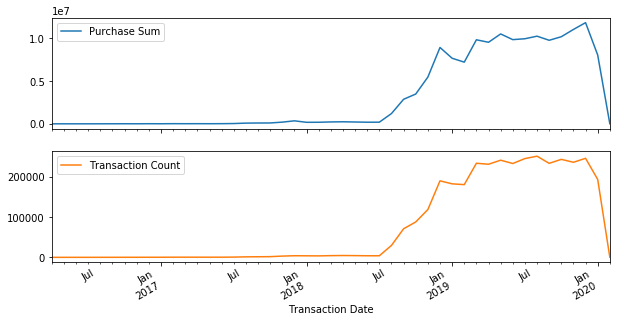

In [5]:
df_group.plot(subplots = True, y= ["Purchase Sum","Transaction Count"], figsize=(10,5));

                  Purchase Sum  Transaction Count
Transaction Date                                 
2018-09-30        2.864154e+06              70906
2018-10-31        3.476955e+06              87826
2018-11-30        5.455445e+06             118630
2018-12-31        8.910758e+06             189849
2019-01-31        7.653694e+06             182379
2019-02-28        7.199211e+06             180404
2019-03-31        9.809226e+06             233468
2019-04-30        9.517425e+06             230990
2019-05-31        1.049074e+07             241047
2019-06-30        9.825952e+06             232827
2019-07-31        9.930230e+06             245095
2019-08-31        1.023078e+07             250985
2019-09-30        9.750168e+06             233238
2019-10-31        1.016536e+07             243126
2019-11-30        1.101461e+07             235863
2019-12-31        1.180695e+07             245742
2020-01-31        8.032002e+06             193349


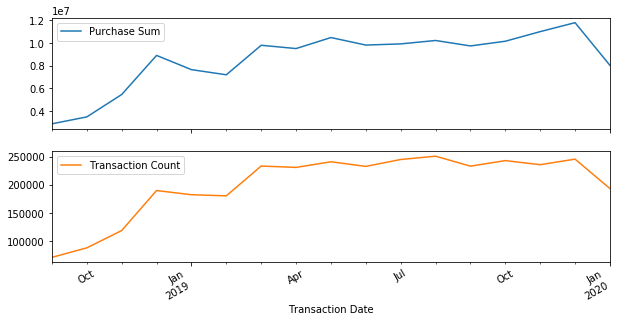

In [6]:
# only keep data from Sep 2018 to Jan 2020
df_period = df_group.loc['2018-09-01':'2020-01-31']
df_period.plot(subplots = True, y= ["Purchase Sum","Transaction Count"], figsize=(10,5));
print(df_period) # 17 month in total